# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация

### Общая информация
Дата выдачи: 09.11.2023

Мягкий дедлайн: 22.11.2023

Жесткий дедлайн: 26.11.2023

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку.

**Оценка**: 11 баллов

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного жёсткого дедлайна нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи

Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-linclass-__Username__.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-linclass-__IvanovIvan__.ipynb).

# Часть 1. SVM, LR и калибровка вероятностей (2 балла + 0.5 бонус)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [2]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт случайный ответ. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [3]:
from sklearn.dummy import DummyClassifier
random_classifier = DummyClassifier(strategy='uniform', random_state=42).fit(X_train, y_train)
y_random = random_classifier.predict_proba(X_test)[:,1]
y_random

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

**Вопрос:** решаем задачу бинарной классификации, но y\_random содержит какие-то дробные числа, а не 0/1. Почему?



**Ответ**: потому что это вероятности, а не сам класс

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно.

In [4]:
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

Random Classifier metrics
AUC-PR: 0.75283
AUC-ROC: 0.50000


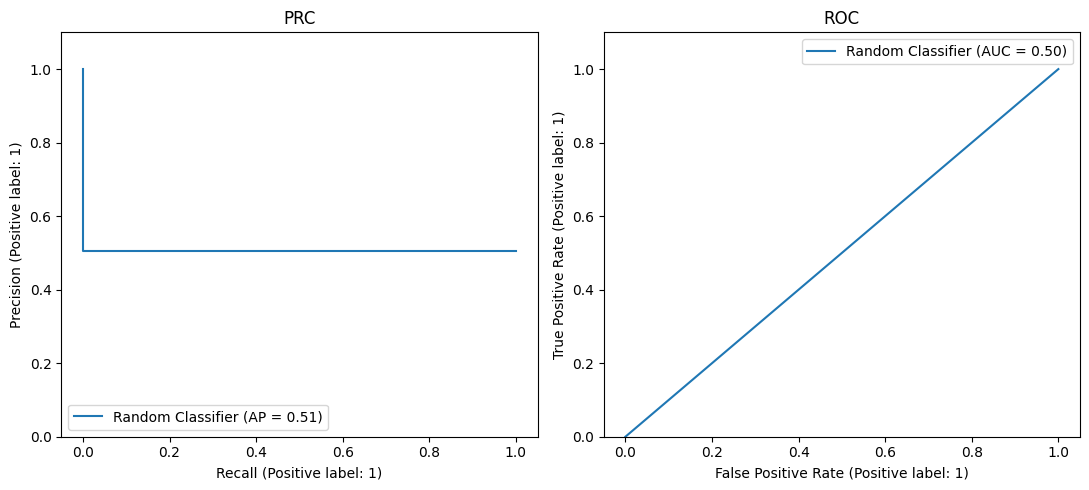

In [5]:
def depict_pr_roc(y_true, y_pred, classifier_name='Some Classifier', ax=None):
  if ax is None:
    fig, ax = plt.subplots(1, 2, figsize=(11, 5))

  print(classifier_name, 'metrics')
  PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=classifier_name)
  precision, recall, _ = precision_recall_curve(y_true, y_pred)
  print('AUC-PR: %.5f' % auc(recall, precision))
  ax[0].set_title("PRC")
  ax[0].set_ylim(0, 1.1)

  RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=classifier_name)
  print('AUC-ROC: %.5f' % roc_auc_score(y_true, y_pred))
  ax[1].set_title("ROC")
  ax[1].set_ylim(0, 1.1)

  plt.tight_layout()
  plt.legend()


depict_pr_roc(y_test, y_random, 'Random Classifier')

In [6]:
# dataframe для сравнения
# методов классификации по метрикам
df_metrics = pd.DataFrame(columns=['AUC_PR', 'AUC_ROC', 'reg_const'])
precision, recall, _ = precision_recall_curve(y_test, y_random)
  # добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
      auc(recall, precision),
      roc_auc_score(y_test, y_random),
      0
]

  # по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.5,0.0


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов.

На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`).

Подберите параметр регуляризации `C` с точки зрения AUC-PR (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).


In [7]:
from sklearn import svm
from sklearn.linear_model import LogisticRegression 

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

In [9]:
from sklearn.metrics import make_scorer

def auc_pr_score(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    return auc(recall, precision)

auc_pr_scorer = make_scorer(auc_pr_score, greater_is_better=True)


from sklearn.model_selection import GridSearchCV

cs = {"C": np.logspace(-10, 10, 20)}

model = svm.LinearSVC(dual='auto')
grid_search = GridSearchCV(model, cs, cv=5, scoring=auc_pr_scorer)
grid_search.fit(X_train, y_train)
best_c_svm = grid_search.best_params_["C"]
print("Best C =" , best_c_svm)
print("Best score =", grid_search.best_score_)

Best C = 0.002335721469090121
Best score = 0.8393585793404595


In [10]:
best_c_svm

0.002335721469090121

  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков

SVM metrics
AUC-PR: 0.82755
AUC-ROC: 0.84692


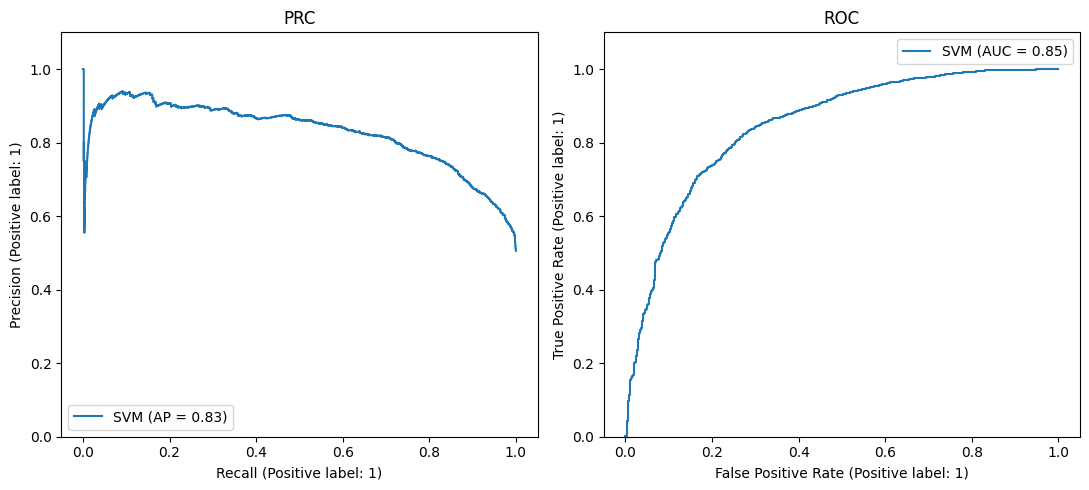

In [11]:
lin_clf = svm.LinearSVC(dual="auto", C=best_c_svm)
lin_clf.fit(X_train, y_train)
y_pred_svm = lin_clf.decision_function(X_test)
y_probabilities = (y_pred_svm - y_pred_svm.min()) / (y_pred_svm.max() -y_pred_svm.min())
depict_pr_roc(y_test, y_probabilities, "SVM")

Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

In [12]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_svm)
df_metrics.loc['SVM'] = [
      auc(recall, precision),
      roc_auc_score(y_test, y_pred_svm),
      best_c_svm
]

df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.500000,0.000000
SVM,0.827554,0.846922,0.002336


__Logistic Regression__


Аналогичное задание для логистической регрессии с L2 регуляризатором:


*   подберите гиперпараметр C, используя метрику AUC-PR
*   нарисуйте ROC, PR кривые для тестовой части
*   выведите метрики для тестовых данных и сравните их с результатами случайного классификатора



In [13]:
cs = {"C": np.logspace(-10, 10, 20)}

model = LogisticRegression(max_iter=1000)
grid_search = GridSearchCV(model, cs, cv=5, scoring=auc_pr_scorer)
grid_search.fit(X_train, y_train)
best_c_log_regr= grid_search.best_params_["C"]
print("Best C =" ,best_c_log_regr)
print("Best score =", grid_search.best_score_)


Best C = 0.002335721469090121
Best score = 0.8403939408335199


In [14]:
best_c_log_regr

0.002335721469090121

Logistic Regression metrics
AUC-PR: 0.83093
AUC-ROC: 0.84589


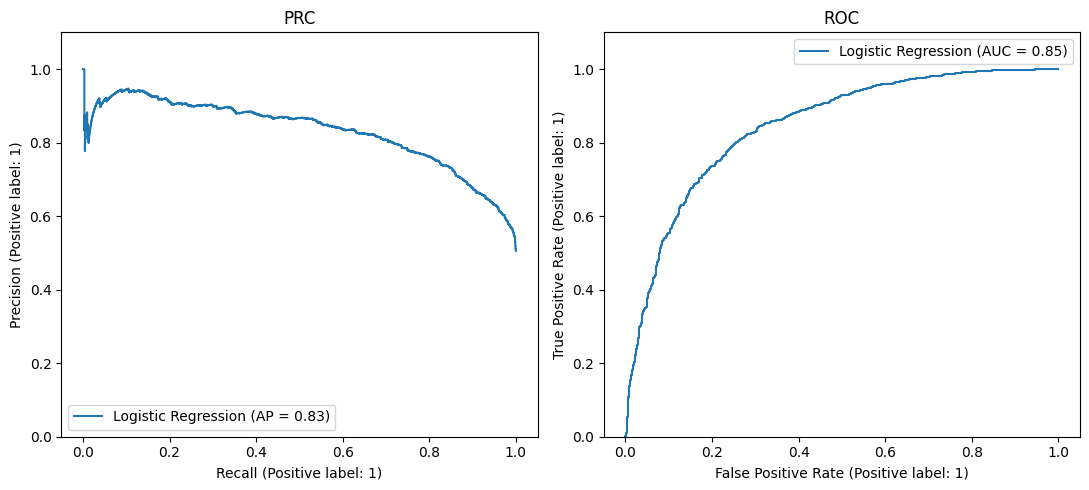

In [15]:
lin_clf = LogisticRegression(penalty='l2', dual=False, C = best_c_log_regr, max_iter=1000)
lin_clf.fit(X_train, y_train)
y_pred_log = lin_clf.predict_proba(X_test)
depict_pr_roc(y_test, y_pred_log[:, 1], "Logistic Regression")

In [16]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_log[:, 1])
df_metrics.loc['LogisticRegression'] = [
      auc(recall, precision),
      roc_auc_score(y_test, y_pred_log[:, 1]),
      best_c_log_regr
]

df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.500000,0.000000
SVM,0.827554,0.846922,0.002336
LogisticRegression,0.830933,0.845888,0.002336


Нарисуйте ROC, PR кривые для тестовой части для всех 3 классификаторов на одном графике

Random Classifier metrics
AUC-PR: 0.75283
AUC-ROC: 0.50000
SVM metrics
AUC-PR: 0.82755
AUC-ROC: 0.84692
Logistic Regression metrics
AUC-PR: 0.83093
AUC-ROC: 0.84589


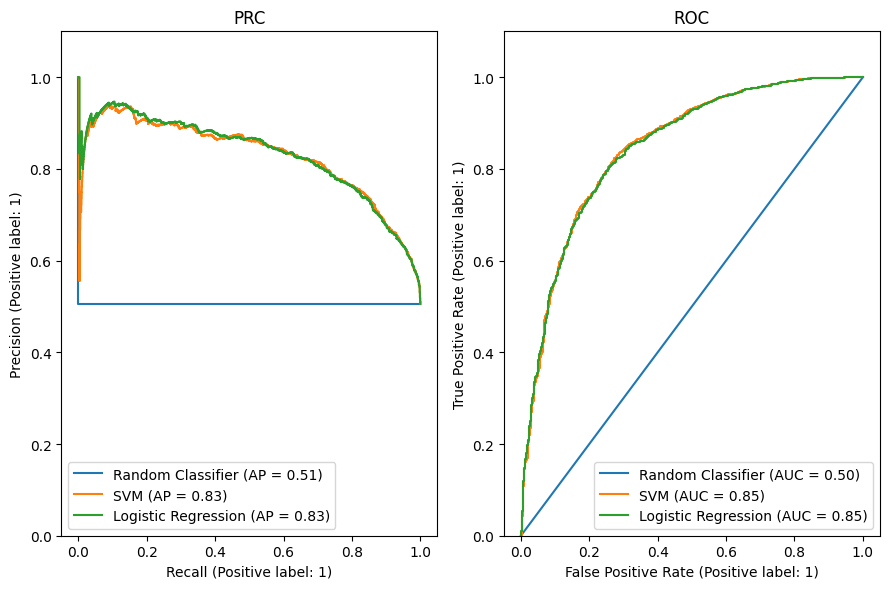

In [17]:
fig, ax = plt.subplots(1, 2, figsize = (9, 6))
depict_pr_roc(y_test, y_random, "Random Classifier", ax = ax)
depict_pr_roc(y_test, y_pred_svm, "SVM", ax = ax)
depict_pr_roc(y_test, y_pred_log[:, 1], "Logistic Regression", ax= ax)


**Вопрос:** Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).



**Ответ:** Результаты на графиках почти идентичные, у SVM ROC-AUC чуть больше, чем у логистической регрессии, а у логистической регрессии чуть лучше AUC-PR.

Разница между этмми методами, что логистическая регрессия сразу выдает вероятности, а SVM выдает отступы, которые руками пришлось переводить в вероятности

#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)



В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

* Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. В этот раз воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах, а в `LinearSVC` нет. Не забудьте зафиксировать seed для воспроизводимости

* Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы (атрибут `support_vectors_`).

In [18]:
X, y = make_classification(
    n_samples=1000, n_features=2, n_informative=2, n_redundant=0, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

SVM metrics
AUC-PR: 0.95545
AUC-ROC: 0.94910


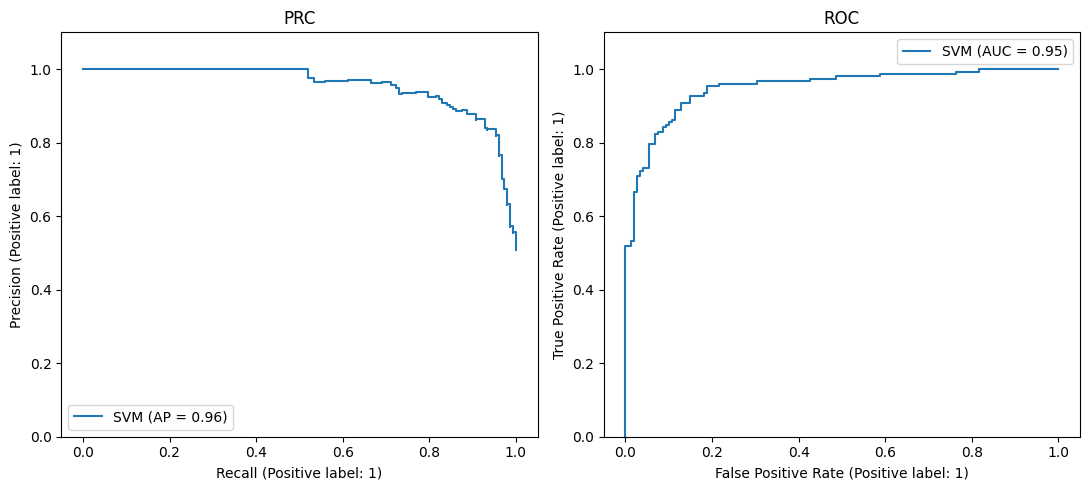

In [19]:
model = svm.SVC(C=best_c_svm, kernel='linear')
model.fit(X_train, y_train)
y_pred_svm_new = model.decision_function(X_test)
y_prob = (y_pred_svm_new - y_pred_svm_new.min()) / (y_pred_svm_new.max() - y_pred_svm_new.min())
depict_pr_roc(y_test, y_prob, "SVM")

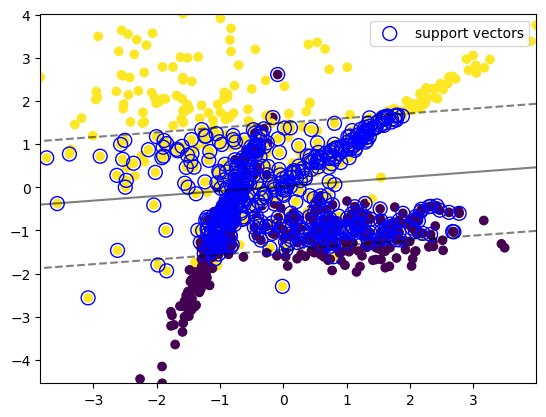

In [20]:
def plot_svm_2D(X, y, model,  plot_support=True):
    #создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 30)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    #Ответы модели для сетки для отрисовки разделяющей прямой
    Z = model.decision_function(xy).reshape(XX.shape)

    plt.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])


    #Отрисовали выборку
    plt.scatter(X[:, 0], X[:, 1], c = y)

    #Отрисовали опорные векторы
    if plot_support:
        plt.scatter(model.support_vectors_[:, 0],
                    model.support_vectors_[:, 1],
                    label='support vectors',
                    s=100,
                    linewidth=1,
                    edgecolor="blue",
                    facecolors='none')

    plt.legend()

plot_svm_2D(X, y, model)

**Вопрос:** какие объекты выделяются как "опорные"?



**Ответ:**  Опорными векторами называются объекты, которые ближе всего находятся к разделяющей гиперплоскости, то есть для которых $|wx + w_0| \le 1$ 

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты.

In [21]:
def plot_logreg_2D(X, y, model):

    #создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 100)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 100)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    #Ответы модели для сетки для отрисовки распределения
    Z = model.predict_proba(xy)[:, 1]
    Z = Z.reshape((xx.shape[0], -1)).T


    image = plt.imshow(Z, interpolation='nearest',
                       extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                       aspect='auto', origin='lower', cmap=plt.cm.PuOr_r)

    #Отрисовали выборку
    plt.scatter(X[:, 0], X[:, 1], c = y, cmap=plt.cm.Paired)

    plt.colorbar(image)

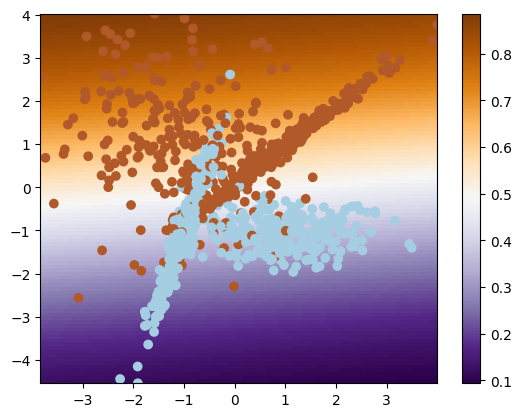

In [22]:
model_log = LogisticRegression(penalty='l2', dual=False, C = best_c_log_regr).fit(X_train, y_train)
plot_logreg_2D(X, y, model_log)

**Вопрос:** Как на картинке визуализирована область, где модель не уверена ($p(y=+1|x) = 0.5$)? Как это обосновать теоритечески?


**Ответ:** 
Мы не можем точно провести плоскость, которая бы разделила все на 2 класса, поэтому мы явно видим, где $p(y=+1|x) = 0.5$. Теоретическое обоснование такое, что если $p(y=+1|x) = 0.5$, то мы рандомно выдаем один из классов

#### __Задание 2. Калибровка вероятностей__ (1 балл)



Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых.

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность?

Хорошо откалиброванный  классификатор должен выдавать значения так, чтобы среди образцов, для которых он дал значение, близкое к $\alpha$, примерно $\alpha * 100 \%$ фактически принадлежали к положительному классу. (Например, если классификатор выдает 0.3 для некоторых, то 30% из них должны принадлежать классу 1)

Для построения калибровочной криовой используем следующий алгоритм:

Разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [23]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2)
        y_seg = y_test[(preds >= l) & (preds < r)]
        bin_real_ratios.append(y_seg.mean()) 
    plt.figure(figsize=(6,6))
    plt.plot([0, 1], [0, 1], '--')
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.ylim([-0.05, 1.05])
    plt.grid()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

Отрисуйте калибровочную кривую идеально откалиброванной модели (диагональ)

In [24]:
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

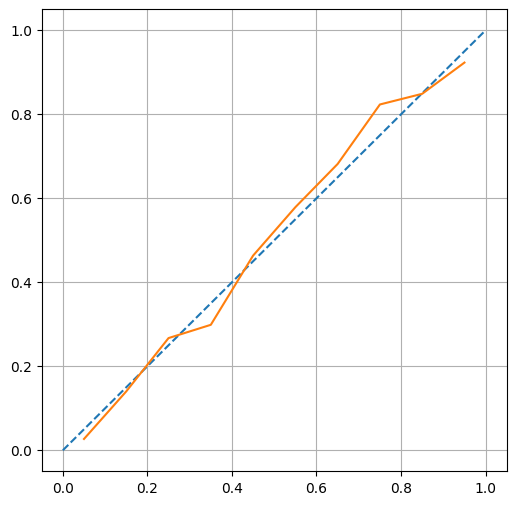

In [25]:
logistic_clf = LogisticRegression(penalty='l2', C=best_c_log_regr).fit(X_train, y_train)
y_log_proba = logistic_clf.predict_proba(X_test)[:,1]
plot_calibration_curve(y_test,y_log_proba )


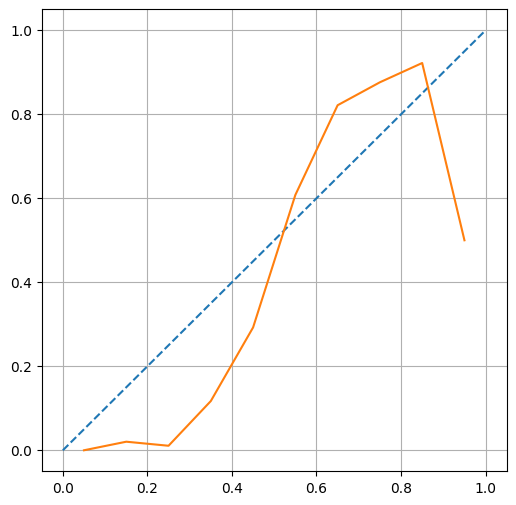

In [26]:
svm_clf = svm.SVC(C=best_c_svm, kernel='linear').fit(X_train, y_train)
svm_decision = svm_clf.decision_function(X_test)
true_svm_decision = (svm_decision - svm_decision.min()) / (svm_decision.max() - svm_decision.min())
plot_calibration_curve(y_test,true_svm_decision)

**Вопрос**: хорошо ли откалиброваны кривые для SVM, логистической регрессии?

**Ответ:** Для логистической регресии достаточно хорошо, а для SVM очень плохо

Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`).

(array([  8.,  49., 186., 401., 636., 727., 594., 315.,  77.,   7.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

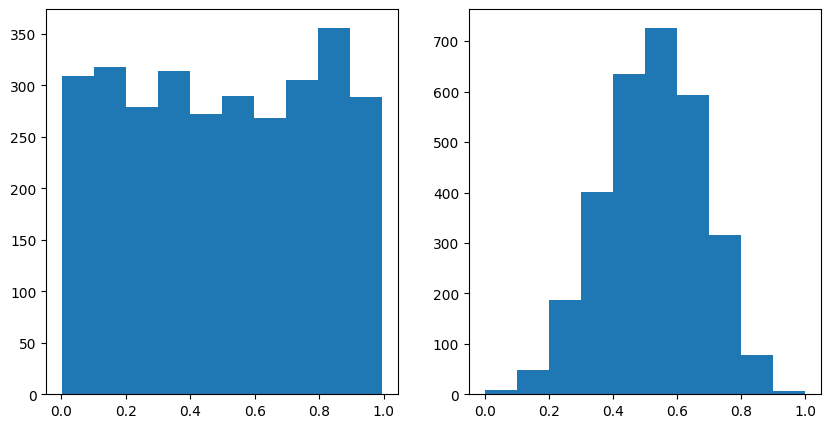

In [27]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax[0].hist(y_log_proba)
ax[1].hist(true_svm_decision)

**Вопрос:** Чем они различаются? Чем вы можете объяснить это?

**Ответ:** У логистической регрессии напоминает нормальное рапределение распределение

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью  предсказания для тестовой выборки.

In [28]:
from sklearn.calibration import CalibratedClassifierCV

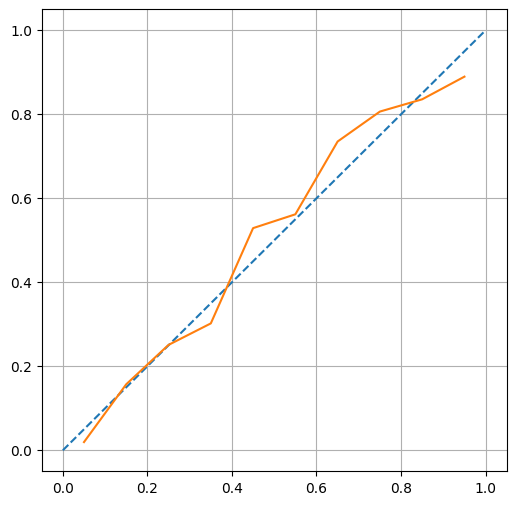

In [29]:
svm_clf = svm.SVC(C=best_c_svm, kernel='linear')
calibrated_clf = CalibratedClassifierCV(svm_clf).fit(X_train, y_train)
svm_probs_calib = calibrated_clf.predict_proba(X_test)[:,1]
plot_calibration_curve(y_test, svm_probs_calib)

**Вопрос:** Улучшилась ли калибровочная кривая?

**Ответ:** Стало гораздо лучше

##### __Бонус: Авторское решение__ (0.5 балла)

Реализуйте свою функцию для калибровки вероятностей, используя любой из известных подходов. Кратко опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

In [30]:
#your code here

# Часть 2. Обработка категориальных переменных (4 балла + 1.5 бонус)

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла.

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

(бесценный шаг)

Разберем датасет [покупок велосипедов](https://www.kaggle.com/datasets/heeraldedhia/bike-buyers/): даны признаки покупателя, требуется предсказать, купит ли он/она велосипед



Замените пропуски в категориальных переменных на новую категорию (`'undefined'`)

Разделите признаки на 2 таблицы: категориальные и числовые признаки

In [31]:
df = pd.read_csv('bike_buyers.csv')
df.isna().sum()

ID                   0
Marital Status       7
Gender              11
Income               6
Children             8
Education            0
Occupation           0
Home Owner           4
Cars                 9
Commute Distance     0
Region               0
Age                  8
Purchased Bike       0
dtype: int64

In [32]:
categorical = ["Marital Status", "Gender", "Education", "Occupation", "Home Owner", "Commute Distance", "Region"]
numerical = ["Income", "Children","Cars" , "Age"]

In [33]:
df[categorical] = df[categorical].fillna("undefined")

In [34]:
X = df.drop(columns=['Purchased Bike'])
y = (df['Purchased Bike'] == 'Yes').astype('int64')

#Разделим на категориальные признаки и числовые
X_numerical = df[numerical]
X_categorical = df[categorical]

В начале поработаем только с категориальными признаками

In [35]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)

In [36]:
X_categorical.isna().sum()

Marital Status      0
Gender              0
Education           0
Occupation          0
Home Owner          0
Commute Distance    0
Region              0
dtype: int64

#### __Задание 3. OrdinalEncoder__  (0.5 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

In [37]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder


In [38]:
column_transformer = ColumnTransformer([
    ("encoder", OrdinalEncoder(), categorical)
])


pipeline = Pipeline([ 
    ('transformer', column_transformer),
    ('log_reg', LogisticRegression(max_iter=200))
    ])

In [39]:
%%time
model = pipeline.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred)
auc_pr = auc(recall, precision)
print(f"AUC-PR: {auc_pr}")

AUC-PR: 0.5789437602089755
CPU times: user 9 ms, sys: 1.41 ms, total: 10.4 ms
Wall time: 9.33 ms


#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

In [40]:
column_transformer = ColumnTransformer([
    ("ohe", OneHotEncoder(), categorical)
])


pipeline = Pipeline([ 
    ('transformer', column_transformer),
    ('log_reg', LogisticRegression())
    ])

In [41]:
%%time
model = pipeline.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred)
auc_pr = auc(recall, precision)
print(f"AUC-PR: {auc_pr}")

AUC-PR: 0.6618645231989089
CPU times: user 13.3 ms, sys: 1.55 ms, total: 14.9 ms
Wall time: 13.8 ms


Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание 5. Mean-target Encoding__ (1 балл)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

In [42]:
from sklearn.preprocessing import FunctionTransformer

In [43]:
class MeanTargetEncoder:
    def __init__(self, columns):
        self.columns = columns
        self.means = {}

    def fit(self, X, y):
        data = pd.concat([X, pd.DataFrame(y)], axis=1)
        for col in self.columns:
            self.means[col] = data.groupby(col)['Purchased Bike'].mean()
        return self
        
    def transform(self, X):
        X_copy = X.copy()
        for col in self.columns:
            X_copy[col] = X_copy[col].map(self.means[col])
        return X_copy


In [44]:
%%time
encoder = MeanTargetEncoder(categorical)
encoder.fit(X_train, y_train)
X_train_new = encoder.transform(X_train)
X_test_new = encoder.transform(X_test)
model = LogisticRegression(max_iter=1000)
model.fit(X_train_new, y_train)
y_pred = model.predict_proba(X_test_new)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR: %.5f' % auc(recall, precision))


AUC-PR: 0.65269
CPU times: user 12.2 ms, sys: 1.74 ms, total: 14 ms
Wall time: 12.8 ms


##### __Бонус: Эффективная реализация (1 балл)__

Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их.

In [45]:
from sklearn.base import BaseEstimator, TransformerMixin

In [46]:
class MeanTargetEncoderNew(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.means = {}

    def fit(self, X, y):
        data = pd.concat([X, pd.DataFrame(y)], axis=1)
        for col in self.columns:
            self.means[col] = data.groupby(col)['Purchased Bike'].mean()
        return self
        
    def transform(self, X):
        X_copy = X.copy()
        for col in self.columns:
            X_copy[col] = X_copy[col].map(self.means[col])
        return X_copy


_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество.

In [47]:
class MeanTargetEncoderNoise:
    def __init__(self, columns):
        self.columns = columns
        self.means = {}

    def fit(self, X, y):
        data = pd.concat([X, pd.DataFrame(y)], axis=1)
        for col in self.columns:
            self.means[col] = data.groupby(col)['Purchased Bike'].mean() + np.random.normal(0, 1, data[col].nunique())
        return self
        
    def transform(self, X):
        X_copy = X.copy()
        for col in self.columns:
            X_copy[col] = X_copy[col].map(self.means[col])
        return X_copy


In [48]:
%%time
encoder = MeanTargetEncoderNoise(categorical)
encoder.fit(X_train, y_train)
X_train_new = encoder.transform(X_train)
X_test_new = encoder.transform(X_test)
model = LogisticRegression(max_iter=1000)
model.fit(X_train_new, y_train)
y_pred = model.predict_proba(X_test_new)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR: %.5f' % auc(recall, precision))


AUC-PR: 0.52313
CPU times: user 12.5 ms, sys: 1.53 ms, total: 14 ms
Wall time: 13.2 ms


**Вопрос:** Сделайте выводы. Помогло ли добавление шума? Почему?

**Ответ:** Добавление шума не помогло, потому что наша модель могла начать неправильно классифицировать некоторые объекты из-за шума, которые раньше классифицировала правильно.

##### __Бонус: другой подход__ (0.5 балла)

Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум).




In [49]:
#your code here

#### __Задание 7. Сглаживание счетчиков__  (1 балл)

> Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке.

> Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше и повторите эксперименты. Подберите $C$, чтобы качество было лучше, чем при использовании One-Hot-Encoding


In [50]:
class MeanTargetEncoderSmmoth:
    def __init__(self, columns, C):
        self.columns = columns
        self.c = C
        self.means = {}

    def fit(self, X, y):
        data = pd.concat([X, pd.DataFrame(y)], axis=1)
        for col in self.columns:
            num = data.groupby(col)['Purchased Bike'].sum() + self.c * y.sum()
            den = data.groupby(col)['Purchased Bike'].count() + self.c
            self.means[col] = num / den
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col in self.columns:
            X_copy[col] = X_copy[col].map(self.means[col])
        return X_copy

        

In [51]:
%%time
possible_c = np.linspace(0, 20, 40)
best_c_smooth = 1e10
best_auc = 0
for c in possible_c:
    encoder = MeanTargetEncoderSmmoth(categorical, c)
    encoder.fit(X_train, y_train)
    X_train_new = encoder.transform(X_train)
    X_test_new = encoder.transform(X_test)
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train_new, y_train)
    y_pred = model.predict_proba(X_test_new)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    cur_auc = auc(recall, precision)
    if (cur_auc > best_auc):
        best_auc = cur_auc
        best_c = c
print(f'best AUC-RC: {best_auc}, best c: {best_c}' )


best AUC-RC: 0.652694015966057, best c: 0.0
CPU times: user 446 ms, sys: 4.18 ms, total: 450 ms
Wall time: 451 ms


#### **Задание 8. Числовые или категориальные?**  (0.5 балла)

Теперь добавим числовые признаки к признакам-счетчикам.


В данных есть пропуски - замените их средним значением признака



In [52]:

X_numerical.loc[X_numerical['Income'].isna(), 'Income'] = X_numerical['Income'].mean()
X_numerical.loc[X_numerical['Children'].isna(), 'Children'] = X_numerical['Children'].mean()
X_numerical.loc[X_numerical['Cars'].isna(), 'Cars'] = X_numerical['Cars'].mean()
X_numerical.loc[X_numerical['Age'].isna(), 'Age'] = X_numerical['Age'].mean()


/var/folders/qc/bt573cmd5cgbhf5f5yhk55740000gn/T/ipykernel_13328/302623343.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_numerical.loc[X_numerical['Income'].isna(), 'Income'] = X_numerical['Income'].mean()
/var/folders/qc/bt573cmd5cgbhf5f5yhk55740000gn/T/ipykernel_13328/302623343.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_numerical.loc[X_numerical['Children'].isna(), 'Children'] = X_numerical['Children'].mean()
/var/folders/qc/bt573cmd5cgbhf5f5yhk55740000gn/T/ipykernel_13328/302623343.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in 

In [53]:
X_numerical.isna().sum()


Income      0
Children    0
Cars        0
Age         0
dtype: int64

In [54]:
X_full = pd.concat((X_categorical, X_numerical), axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_full, y, test_size=0.25, random_state=777, stratify=y)

 Сейчас для числовых признаков мы ищем линейную зависимость, что в общем случае  может быть неверной гипотезой. Тем не менее, у этих признаков есть довольно много уникальных значений (сколько?), поэтому применять к ним one-hot кодирование может оказаться излишним. Попробуйте закодировать эти признаки с помощью счетчиков (вместе и по отдельности). Стало ли лучше?

In [55]:
for col in numerical:
    print(f'number of unique values for {col} : {len(X_train[col].unique())}')

number of unique values for Income : 17
number of unique values for Children : 7
number of unique values for Cars : 6
number of unique values for Age : 54


In [56]:
copy_categorical = categorical

In [57]:
%%time

for num_feature in numerical:
    new_category = copy_categorical + list(num_feature.split(" "))
    encoder = MeanTargetEncoderSmmoth(new_category, best_c)
    encoder.fit(X_train[new_category], y_train)
    X_train_new = encoder.transform(X_train[new_category])
    X_test_new = encoder.transform(X_test[new_category])
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train_new, y_train)
    y_pred = model.predict_proba(X_test_new)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    print(f'AUC-PR with encoded {num_feature}: {auc(recall, precision)}'  )
    new_category.pop()


AUC-PR with encoded Income: 0.70253563293164
AUC-PR with encoded Children: 0.6461823534801353
AUC-PR with encoded Cars: 0.6885255939777031
AUC-PR with encoded Age: 0.6235509973818814
CPU times: user 52.5 ms, sys: 2.16 ms, total: 54.7 ms
Wall time: 53.6 ms


Посмотрим на кодировку всех признаков вместе:

In [58]:
all_categories = categorical + numerical

In [59]:
%%time


encoder = MeanTargetEncoderSmmoth(all_categories, best_c)
encoder.fit(X_train, y_train)
X_train_new = encoder.transform(X_train)
X_test_new = encoder.transform(X_test)
model = LogisticRegression()
model.fit(X_train_new, y_train)
y_pred = model.predict_proba(X_test_new)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR: %.5f' % auc(recall, precision))


AUC-PR: 0.66293
CPU times: user 16.5 ms, sys: 1.79 ms, total: 18.3 ms
Wall time: 17.2 ms


> __Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).



Как мы могли пронаблюдать, счётчики являются конкурентной альтернативой one-hot-кодированию. Опишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__  со счетчиками легче получить переобучение, поэтому за этим нужно внимательно следить. ohe создает много колонок, что сильно усложняет модель, но дает хороший результат

# Часть 3. Отбор признаков (2 балла)

Загрузим данные [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет.

In [60]:
# !wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

In [61]:
columns = ['age', 'workclass', 'fnlwgt', 'education',
           'education-num', 'marital-status', 'occupation',
           'relationship', 'race', 'sex', 'capital-gain',
           'capital-loss', 'hours-per-week', 'native-country',
           'income']

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')
df.sample()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
31783,54,Private,178946,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,48,United-States,1


Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.



Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`.

In [62]:
X = df.drop(columns = 'income')
y = df['income']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

In [63]:
X_train

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
14004,60,State-gov,194252,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,3103,0,40,United-States
21060,41,Local-gov,26669,Some-college,10,Divorced,Exec-managerial,Not-in-family,White,Female,0,0,40,United-States
7926,18,Private,165754,Some-college,10,Never-married,Other-service,Own-child,White,Female,0,0,30,United-States
11552,61,Local-gov,115023,HS-grad,9,Married-civ-spouse,Other-service,Husband,White,Male,0,0,40,United-States
15648,26,Self-emp-not-inc,93806,Some-college,10,Married-civ-spouse,Sales,Husband,White,Male,0,0,55,United-States
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18970,20,Private,94744,HS-grad,9,Never-married,Adm-clerical,Own-child,Black,Female,0,0,20,United-States
21382,62,Local-gov,41793,Masters,14,Separated,Prof-specialty,Not-in-family,White,Female,0,0,50,?
10830,47,Private,152073,HS-grad,9,Divorced,Machine-op-inspct,Unmarried,White,Female,0,0,40,United-States
14560,33,Private,222221,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,7298,0,45,United-States


In [64]:
categorical = ['workclass', 'education', 'marital-status','occupation', 'relationship', 'race', 'sex', 'native-country']
numerical = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

Давайте закодируем все категориальные признаки с помощью One-hot Encoding. Сколько новых признаков мы получим?

In [65]:
enc = OneHotEncoder(sparse_output=False)
X_train_enc = pd.DataFrame(enc.fit_transform(X_train[categorical]),columns=enc.get_feature_names_out(input_features=categorical)).reset_index()
X_test_enc = pd.DataFrame(enc.transform(X_test[categorical]),columns=enc.get_feature_names_out(input_features=categorical)).reset_index()
X_train_enc.shape

(24420, 103)

In [66]:
X_train_encoded = pd.concat((X_train_enc, X_train[numerical].reset_index()), axis = 1)
X_test_encoded = pd.concat((X_test_enc, X_test[numerical].reset_index()), axis = 1)


In [67]:
X_train_encoded.drop(columns ='index', inplace=True)
X_test_encoded.drop(columns ='index', inplace=True)


Было 14 колонок, а стало 103

В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [68]:
model= LogisticRegression(max_iter=1000)
model.fit(X_train_encoded, y_train)
y_pred = model.predict_proba(X_test_encoded)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR: %.5f' % auc(recall, precision))

AUC-PR: 0.45033


#### __Задание 9. Встроенные методы (0.5 балла)__

Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.



In [69]:
%%time
coefs = np.abs(model.coef_)

res = sorted(np.argsort(coefs[0]))
best_fourty = res[:40]
X_train_best = X_train_encoded.iloc[:, best_fourty]
X_test_best = X_test_encoded.iloc[:, best_fourty]
model= LogisticRegression(max_iter = 1000)
model.fit(X_train_best, y_train)
y_pred = model.predict_proba(X_test_best)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR: %.5f' % auc(recall, precision))

AUC-PR: 0.67352
CPU times: user 4.01 s, sys: 37.7 ms, total: 4.05 s
Wall time: 590 ms


Изменилось ли качество? Как?

Качество сильно улучшилось

Подумаем, что мы не учли. Мы действовали в предположении, что признаки вносят вклад равномерно, и не учитывали их масштаб. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки.

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [70]:
from sklearn.preprocessing import StandardScaler

In [71]:
column_transformer = ColumnTransformer([
    ("ohe", OneHotEncoder(), categorical),
    ("scaler" , StandardScaler(), numerical)
])


pipeline = Pipeline([ 
    ('transformer', column_transformer),
    ('log_reg', LogisticRegression(C=best_c_log_regr))
    ])

In [72]:
model = pipeline.fit(X_train, y_train)
pred = model.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR: %.5f' % auc(recall, precision))

AUC-PR: 0.67352


Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [73]:
scaler = StandardScaler()
X_train_encoded_sc = scaler.fit_transform(X_train_encoded)
X_test_encoded_sc = scaler.fit_transform(X_test_encoded)

model = LogisticRegression(C= best_c_log_regr)
model.fit(X_train_encoded_sc, y_train)
y_pred = model.predict_proba(X_test_encoded_sc)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR: %.5f' % auc(recall, precision))


AUC-PR: 0.75274


Качество еще улучшилось

#### __Задание 10. Методы фильтрации (0.5 балла)__


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods.

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

Оставьте 40 признаков с наибольшим значением $t$, замерьте качество и скорость отбора признаков.



In [74]:
def compute_t(X, y):
    data = pd.concat((pd.DataFrame(X), pd.DataFrame(y)), axis = 1)
    positive_table = data[data['income'] == 1]
    negative_table = data[data['income'] == 0]
    positive = positive_table.drop(columns = 'income')
    negative = negative_table.drop(columns = 'income')

    den = np.sqrt((positive.shape[0] * np.var(positive, axis = 0) + negative.shape[0] * np.var(negative, axis = 0)) / (positive.shape[0]+negative.shape[0]))
    return np.abs(np.mean(positive, axis = 0) - np.mean(negative, axis = 0))  / den

In [75]:
%%time
statistics = compute_t(X_train_encoded_sc, y_train)
res = sorted(np.argsort(statistics))
best_fourty = res[:40]

X_train_best = pd.DataFrame(X_train_encoded_sc).iloc[:, best_fourty]
X_test_best = pd.DataFrame(X_test_encoded_sc).iloc[:, best_fourty]
model= LogisticRegression(C=best_c_log_regr, max_iter=1000)
model.fit(X_train_best, y_train)
y_pred = model.predict_proba(X_test_best)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR: %.5f' % auc(recall, precision))

AUC-PR: 0.67416
CPU times: user 548 ms, sys: 20.7 ms, total: 569 ms
Wall time: 125 ms


#### __Задание 11. Методы-обёртки__ (1 балл)

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества). Более конкретно, на каждом шаге мы будем удалять такой признак $j$, что качество модели на множестве оставшихся признаков без $j$ максимально, то есть удалять мы будем наиболее бесполезный признак.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только для финальной оценки качества.

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [76]:
X_train_val, X_val, y_train_val, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=777, stratify=y_train)

In [77]:
enc = OneHotEncoder(sparse_output=False)
X_train_val_enc = pd.DataFrame(enc.fit_transform(X_train_val[categorical]),columns=enc.get_feature_names_out(input_features=categorical))
X_val_enc = pd.DataFrame(enc.transform(X_val[categorical]),columns=enc.get_feature_names_out(input_features=categorical))
X_train_val_enc[numerical] = scaler.fit_transform(X_train_val[numerical])
X_val_enc[numerical] = scaler.transform(X_val[numerical])


In [78]:
copy_X_train_val_enc = X_train_val_enc
copy_X_val_enc = X_val_enc
while copy_X_train_val_enc.shape[1] > 40:
    aucs = []
    columns = copy_X_train_val_enc.columns
    for feature in columns:
        model = LogisticRegression(max_iter=1000).fit(copy_X_train_val_enc.drop(columns=[feature]), y_train_val)
        y_pred = model.predict_proba(copy_X_val_enc.drop(columns=[feature]))[:, 1]
        precision, recall, _ = precision_recall_curve(y_val, y_pred)
        aucs.append(auc(recall, precision))
    maximum = np.argmax(aucs)
    copy_X_train_val_enc.drop(columns=columns[maximum], inplace=True)
    copy_X_val_enc.drop(columns=columns[maximum], inplace=True)
    print('AUC:', np.max(aucs))

AUC: 0.7655784869471667
AUC: 0.7657986762640651
AUC: 0.7659242708665884
AUC: 0.7660065853562379
AUC: 0.7660910800399804
AUC: 0.7666568534728053
AUC: 0.7667779263195842
AUC: 0.7668855158481434
AUC: 0.7670213921070682
AUC: 0.7671763205649939
AUC: 0.7672526427130503
AUC: 0.7673351900617109
AUC: 0.7673931072983216
AUC: 0.76760037115781
AUC: 0.7676571805650991
AUC: 0.7677105570730477
AUC: 0.7677801595557501
AUC: 0.767828299909403
AUC: 0.7678480136009731
AUC: 0.767871080984133
AUC: 0.7678901976603356
AUC: 0.7679090228982627
AUC: 0.7679216750123763
AUC: 0.7679291233076555
AUC: 0.7679424549620786
AUC: 0.7679562986063726
AUC: 0.7679650813990211
AUC: 0.7680896820539428
AUC: 0.7681506243886025
AUC: 0.7682009641924245
AUC: 0.7682294209748345
AUC: 0.7685394819113402
AUC: 0.7685847618737898
AUC: 0.768620546561128
AUC: 0.7686478569891382
AUC: 0.7686720994490275
AUC: 0.7686762840142576
AUC: 0.7686891642675455
AUC: 0.7686821034335171
AUC: 0.7686970552621104
AUC: 0.7686999959847907
AUC: 0.76869971325151

In [93]:

X_test_enc = pd.DataFrame(enc.transform(X_test[categorical]),columns=enc.get_feature_names_out(input_features=categorical))
X_test_enc[numerical] = scaler.transform(X_test[numerical])


In [96]:
X_test_enc_best = X_test_enc[list(copy_X_train_val_enc.columns)]

In [97]:
model = LogisticRegression(max_iter=1000)
model.fit(copy_X_train_val_enc, y_train_val)
y_pred = model.predict_proba(X_test_enc_best)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred)
auc_pr_val = auc(recall, precision)
print('For test AUC-PR: %.5f' % auc(recall, precision))

For test AUC-PR: 0.76509


Здесь скор упал, потому что я не делала standart scaler для категориальных

отбор занял 15 минут

Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ по одному самому полезному признаку в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [89]:
columns = list(X_train_val_enc.columns)
# columns

In [84]:
columns_include = []
while len(columns_include) < 40:
    aucs = []
    for feature in columns:
        model = LogisticRegression(max_iter=1000).fit(X_train_val_enc[columns_include + [feature]], y_train_val)
        y_pred = model.predict_proba(X_val_enc[columns_include + [feature]])[:, 1]
        precision, recall, _ = precision_recall_curve(y_val, y_pred)
        aucs.append(auc(recall, precision))

    print('AUC: ',  np.max(aucs))
    maximum = np.argmax(aucs)
    columns_include.append(columns[maximum])
    columns.remove(columns[maximum])

AUC:  0.6728945213155739
AUC:  0.6754867119764292
AUC:  0.6779667690083027
AUC:  0.6804076152528715
AUC:  0.6861986148100415
AUC:  0.7233167304612933
AUC:  0.733308830748948
AUC:  0.7399317822666469
AUC:  0.7442122456045001
AUC:  0.7491685047266603
AUC:  0.7524543193998721
AUC:  0.754633974907704
AUC:  0.7559288394143336
AUC:  0.7571311863203644
AUC:  0.7582677423223486
AUC:  0.759132075466742
AUC:  0.7601561508503392
AUC:  0.7608616310297918
AUC:  0.7615640564738568
AUC:  0.7624748369592397
AUC:  0.7629916583609511
AUC:  0.7635611725973733
AUC:  0.7638604877543659
AUC:  0.7641723817270962
AUC:  0.764574747260969
AUC:  0.7649312771067721
AUC:  0.7652904617489054
AUC:  0.7655951698437501
AUC:  0.7658627082302211
AUC:  0.766101810229289
AUC:  0.7662924731767348
AUC:  0.766471039083771
AUC:  0.766638910130574
AUC:  0.7667815059553255
AUC:  0.766944658104466
AUC:  0.7670788844032366
AUC:  0.7672017528744273
AUC:  0.7673382036919941
AUC:  0.7674711573257582
AUC:  0.7675935647479204


In [87]:
X_test_rev = X_test_enc[columns_include]

In [88]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train_val_enc[columns_include], y_train_val)
y_pred = model.predict_proba(X_test_rev)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred)
auc_pr_val = auc(recall, precision)
print('For test AUC-PR: %.5f' % auc(recall, precision))

For test AUC-PR: 0.76426


Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:** Огромный недостаток метода, убирать самые незначительные признаки в том, как долго он работает. Лучше результат показал метод, когда мы от 0 признаков идем к 40 и он отработал за 30 секунд

# Часть 4. Оценка экономического эффекта модели (2 балла)



В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно:
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание 12. Прогноз по доходам и расходам__ (1 балл)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [166]:
# !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
# !unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')


In [167]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [168]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте 5 фолдов, сделайте `shuffle=True, random_state=500`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки.

In [169]:
from sklearn.model_selection import KFold

In [170]:
kf = KFold(n_splits=5,shuffle=True, random_state=500)


Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков и `StandardScaler` для числовых, гиперпараметры по умолчанию) и сделайте предсказания для соответствующих тестовых выборок.

In [171]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [172]:
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,442,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


In [173]:
categorical = ['job', 'marital', 'education', 'default', 'housing', 'loan','contact', 'month', 'day_of_week', 'poutcome']
numerical = ['age', 'campaign',	'pdays','previous',	'emp.var.rate',	'cons.price.idx','cons.conf.idx','euribor3m','nr.employed']

In [175]:
precisions = []
recalls = []
y_true_y_pred = []
for i, (train_index, test_index) in enumerate(kf.split(X)):
    column_transformer = ColumnTransformer([
        ("ohe", OneHotEncoder(), categorical),
        ("scaler" , StandardScaler(), numerical)
    ])


    pipeline = Pipeline([ 
        ('transformer', column_transformer),
        ('log_reg', LogisticRegression(max_iter = 1000))
    ])
    
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    X_test = X.iloc[test_index]
    y_test = y.iloc[test_index]
    model = pipeline.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    precisions.append(precision)
    recalls.append(recall)
    y_true_y_pred.append((y_test, y_pred))
    print('AUC-PR: %.5f' % auc(recall, precision))


AUC-PR: 0.52443
AUC-PR: 0.47753
AUC-PR: 0.47238
AUC-PR: 0.50834
AUC-PR: 0.45327


Допустим, работники вашего колл-центра получают за один звонок клиенту 1 доллар. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить. Посчитайте на всех тестовых выборках выручку и усредните. Также вычислите стандартное отклонение.
- Сколько денег вы в среднем заработаете?
- Сколько из заработанных денег придётся отдать операторам вашего колл-центра?

In [176]:
average_revenue = 0
av_expenses = 0
TP = 0
FN = 0
revenue = []
expenses = []
for y_true, y_pred in y_true_y_pred:
    exp = y_pred.sum()
    rev = (y_pred[(y_true == 1)] * 10).sum()
    revenue.append(rev)
    expenses.append(exp)
average_revenue = np.mean(revenue)
av_expenses = np.mean(expenses)
print("Заработали:", average_revenue)
print("Отдаем:", av_expenses)



Заработали: 2130.0
Отдаем: 324.2


Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента. Что получилось?

In [177]:
from scipy.stats import uniform

In [178]:
average_revenue = 0
av_expenses = 0
TP = 0
FN = 0
revenue = []
expenses = []
for y_true, y_pred in y_true_y_pred:
    exp = y_pred.sum()
    rev = (y_pred[(y_true == 1)] * np.random.uniform(0, 20, y_pred[(y_true == 1)].shape)).sum()
    revenue.append(rev)
    expenses.append(exp)
average_revenue = np.mean(revenue)
av_expenses = np.mean(expenses)
print("Заработали:", average_revenue)
print("Отдаем:", av_expenses)



Заработали: 2059.344809005525
Отдаем: 324.2


Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента, укажите стандартные отклонения (вам поможет `plt.errorbar`, [пример](https://jakevdp.github.io/PythonDataScienceHandbook/04.03-errorbars.html)).

Заработали: 2826.0391034093927, отдаем: 928.1416409787207, коэффициент регуляризации: 0.1
Заработали: 2813.8813008872057, отдаем: 928.1228789271423, коэффициент регуляризации: 0.5623413251903491
Заработали: 2813.708126811986, отдаем: 928.146134435993, коэффициент регуляризации: 3.1622776601683795
Заработали: 2897.3051481261236, отдаем: 928.148400619848, коэффициент регуляризации: 17.78279410038923
Заработали: 2861.4539806769294, отдаем: 928.1348869684625, коэффициент регуляризации: 100.0


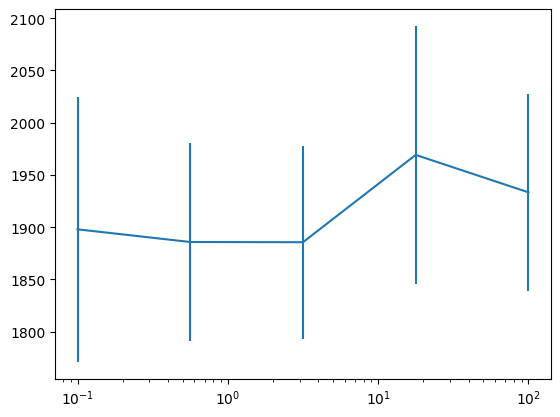

In [179]:
def find_c(best_c):   
    best_income = -1e9 
    cs = np.logspace(-1, 2, 5)
    x_graph = []
    y_graph = []
    std = []
    for c in cs:
        precisions = []
        recalls = []
        average_revenue = 0
        av_expenses = 0
        revenue = []
        expenses = []
        for _, (train_index, test_index) in enumerate(kf.split(X)):
            column_transformer = ColumnTransformer([
                ("ohe", OneHotEncoder(), categorical),
                ("scaler" , StandardScaler(), numerical)
            ])


            pipeline = Pipeline([ 
                ('transformer', column_transformer),
                ('log_reg', LogisticRegression(C=c, max_iter = 1000))
            ])
            
            X_train = X.iloc[train_index]
            y_train = y.iloc[train_index]
            X_test = X.iloc[test_index]
            y_test = y.iloc[test_index]
            model = pipeline.fit(X_train, y_train)
            y_pred = model.predict_proba(X_test)[:, 1]
            precision, recall, _ = precision_recall_curve(y_test, y_pred)
            precisions.append(precision)
            recalls.append(recall)
            exp = y_pred.sum()
            rev = (y_pred[(y_test == 1)] * np.random.uniform(0, 20, y_pred[(y_test == 1)].shape)).sum()
            revenue.append(rev)
            expenses.append(exp)
            

        average_revenue = np.mean(revenue)
        av_expenses = np.mean(expenses)
        print(f'Заработали: {average_revenue}, отдаем: {av_expenses}, коэффициент регуляризации: {c}')
        if (average_revenue - av_expenses >= best_income):
            best_income = average_revenue - av_expenses
            best_c = c

        x_graph.append(c)
        y_graph.append( np.mean(revenue) - np.mean(expenses))
        std.append(np.std(revenue))
    plt.errorbar(x_graph, y_graph, std)
    plt.xscale('log')
    plt.show()
    return best_c
best_c = find_c(1e9)

In [184]:
print(best_c)

3.1622776601683795


Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

Заработали: 2824.8790237373846, отдаем: 928.1416409787207, коэффициент регуляризации: 0.1
Заработали: 2813.7103028342763, отдаем: 928.1228789271423, коэффициент регуляризации: 0.5623413251903491
Заработали: 2829.0189900999735, отдаем: 928.146134435993, коэффициент регуляризации: 3.1622776601683795
Заработали: 2875.1441679871446, отдаем: 928.148400619848, коэффициент регуляризации: 17.78279410038923
Заработали: 2835.9506087008026, отдаем: 928.1348869684625, коэффициент регуляризации: 100.0


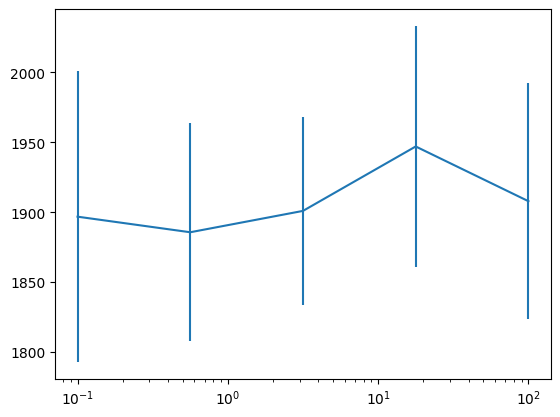

end of run, best c= 17.78279410038923
Заработали: 2808.385552666063, отдаем: 928.1416409787207, коэффициент регуляризации: 0.1
Заработали: 2818.9886139955333, отдаем: 928.1228789271423, коэффициент регуляризации: 0.5623413251903491
Заработали: 2825.0845650390547, отдаем: 928.146134435993, коэффициент регуляризации: 3.1622776601683795
Заработали: 2805.266437981868, отдаем: 928.148400619848, коэффициент регуляризации: 17.78279410038923
Заработали: 2806.5519174762894, отдаем: 928.1348869684625, коэффициент регуляризации: 100.0


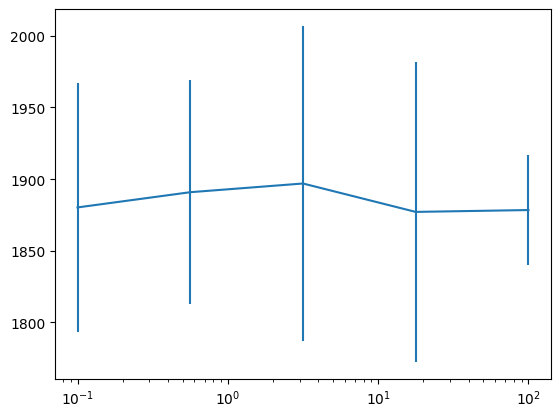

end of run, best c= 3.1622776601683795
Заработали: 2788.5602020198066, отдаем: 928.1416409787207, коэффициент регуляризации: 0.1
Заработали: 2861.4550716216554, отдаем: 928.1228789271423, коэффициент регуляризации: 0.5623413251903491
Заработали: 2854.699585016121, отдаем: 928.146134435993, коэффициент регуляризации: 3.1622776601683795
Заработали: 2830.7728184232274, отдаем: 928.148400619848, коэффициент регуляризации: 17.78279410038923
Заработали: 2853.070247308469, отдаем: 928.1348869684625, коэффициент регуляризации: 100.0


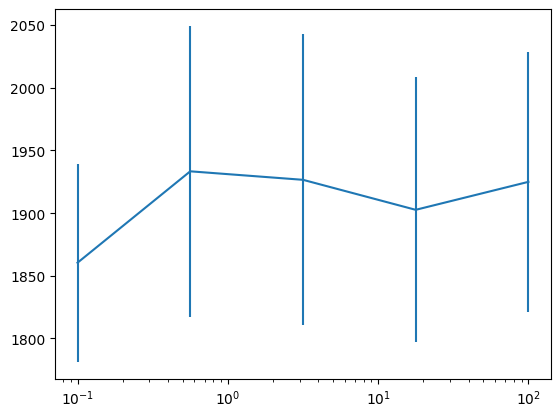

end of run, best c= 0.5623413251903491
Заработали: 2792.779773644057, отдаем: 928.1416409787207, коэффициент регуляризации: 0.1
Заработали: 2818.032954948392, отдаем: 928.1228789271423, коэффициент регуляризации: 0.5623413251903491
Заработали: 2853.253413950462, отдаем: 928.146134435993, коэффициент регуляризации: 3.1622776601683795
Заработали: 2876.702772693022, отдаем: 928.148400619848, коэффициент регуляризации: 17.78279410038923
Заработали: 2785.940037328347, отдаем: 928.1348869684625, коэффициент регуляризации: 100.0


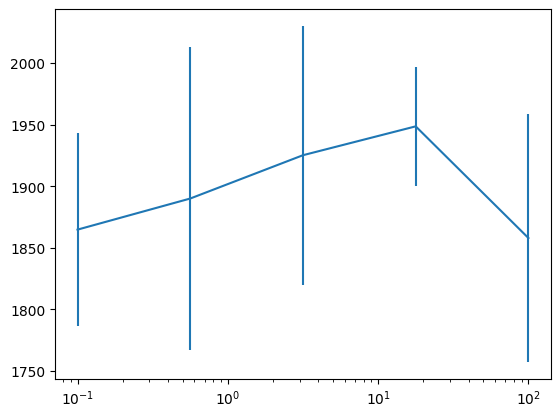

end of run, best c= 17.78279410038923


In [185]:
for i in range(4):
    best_c = find_c(1e8)
    print('end of run, best c=', best_c)

Закономерность найти сложно, потому что графики очень сильно шатает и лучшее c все время разное

#### __Задание 13. Ключевая метрика__ (1 балл)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ обычно в бизнесе хотят найти баланс между precision и recall, но в данной задаче модель скорее хочет максимизировать recall

precision важнее, когда ошибки ложноположительных классов очень критичны (что в данном случае не является таковым). Recall же важнее, когда пропуск положительного класса критичен. Здесь цена звонка маленькая, поэтому ошибки совсем не критичны

> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот.

Заработали: 9349.137462444396, отдаем: 8237.6, порог: 0.0
Заработали: 9226.290391003771, отдаем: 8234.2, порог: 0.01
Заработали: 9138.807286073468, отдаем: 8156.8, порог: 0.02
Заработали: 9175.310062893668, отдаем: 7506.2, порог: 0.03
Заработали: 8520.370652965072, отдаем: 6143.4, порог: 0.04
Заработали: 8062.11875131638, отдаем: 4874.0, порог: 0.05
Заработали: 7414.887290691533, отдаем: 3803.2, порог: 0.06
Заработали: 6879.287759450994, отдаем: 2985.4, порог: 0.07
Заработали: 6439.848657650355, отдаем: 2475.6, порог: 0.08
Заработали: 6234.433058765075, отдаем: 2142.8, порог: 0.09
Заработали: 6119.220844606401, отдаем: 1934.4, порог: 0.1
Заработали: 5965.540056884674, отдаем: 1771.4, порог: 0.11
Заработали: 5795.854768168908, отдаем: 1639.4, порог: 0.12
Заработали: 5727.866467544211, отдаем: 1539.2, порог: 0.13
Заработали: 5690.325408073691, отдаем: 1472.4, порог: 0.14
Заработали: 5606.5321057637375, отдаем: 1428.8, порог: 0.15
Заработали: 5578.418557897549, отдаем: 1391.2, порог: 0.16

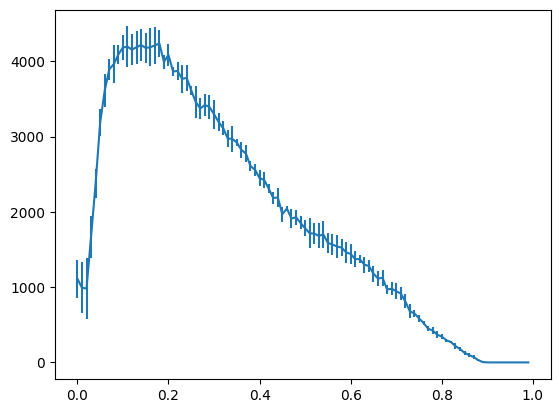

In [186]:
def find_t(best_t):    
    possible_t = np.arange(0, 1, 0.01)
    kf = KFold(n_splits=5,shuffle=True, random_state=500)
    x_graph = []
    y_graph = []
    std = []
    best_revenue = -1e9
    for t in possible_t:
        average_revenue = 0
        av_expenses = 0
        revenue = []
        expenses = []
        for _, (train_index, test_index) in enumerate(kf.split(X)):
            column_transformer = ColumnTransformer([
                ("ohe", OneHotEncoder(), categorical),
                ("scaler" , StandardScaler(), numerical)
            ])


            pipeline = Pipeline([ 
                ('transformer', column_transformer),
                ('log_reg', LogisticRegression(max_iter = 1000))
            ])
            X_train = X.iloc[train_index]
            y_train = y.iloc[train_index]
            X_test = X.iloc[test_index]
            y_test = y.iloc[test_index]
            model = pipeline.fit(X_train, y_train)
            y_pred_proba = model.predict_proba(X_test)
            exp = np.count_nonzero(y_pred_proba[:, 1] >= t)
            rev = (y_test[(y_pred_proba[:, 1] >= t)] * np.random.uniform(0, 20, y_test[(y_pred_proba[:, 1] >= t)].shape)).sum()
            revenue.append(rev)
            expenses.append(exp)
        average_revenue = np.mean(revenue)
        av_expenses = np.mean(expenses)
        print(f'Заработали: {average_revenue}, отдаем: {av_expenses}, порог: {t}')
        if (average_revenue - av_expenses >= best_revenue):
            best_revenue = average_revenue - av_expenses
            best_t = t
        x_graph.append(t)
        y_graph.append( np.mean(revenue) - np.mean(expenses))
        std.append(np.std(revenue))
    plt.errorbar(x_graph, y_graph, std)
    plt.xscale('linear')
    plt.show()
    return best_t
best_t = find_t(1e9)

In [187]:
print(best_t)

0.18


Постройте график зависимости прибыли от порога бинаризации, также отметьте на нем стандартные отклонения. Выделите наилучший порог.




__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

__Ответ:__  оптимальный порог - 0,12. Это связано с тем, что мы идем от ситуации, когда никому не звоним к ситуации, когда мы звоним всем, обе они являются невыгодными для бизнеса

Каковы значения precision и recall на выбранном пороге? Оцените по кросс-валидации. Также вычислите стандартное отклонение.

In [188]:
precisions = []
recalls = []
for _, (train_index, test_index) in enumerate(kf.split(X)):
    column_transformer = ColumnTransformer([
        ("ohe", OneHotEncoder(), categorical),
        ("scaler" , StandardScaler(), numerical)
    ])


    pipeline = Pipeline([ 
        ('transformer', column_transformer),
        ('log_reg', LogisticRegression(max_iter = 1000))
    ])
    
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    X_test = X.iloc[test_index]
    y_test = y.iloc[test_index]
    model = pipeline.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)
    y_pred = y_pred_proba[:, 1]
    y_pred[y_pred >= best_t] = 1
    y_pred[y_pred < best_t] = 0
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    precisions.append(precision)
    recalls.append(recall)
    
print(f'mean precision: {np.mean(precisions)}, mean recall: {np.mean(recalls)}')
print(f'std precision: {np.std(precisions)}, std recall: {np.std(recalls)}')



mean precision: 0.5085725739150928, mean recall: 0.5278392104826004
std precision: 0.36859713784027087, std recall: 0.4102964245356635


Можно пронаблюдать, что наша модель склоняется к более высокому recall. Попробуйте оценить качество модели с помощью `PR-AUC` в зоне recall $\geq$ 0.5. Сделайте это следующим образом:
- выберите только те пороги, на которых достигается необходимый recall,
- затем интерпретируйте отсеченный в единичном квадрате прямоугольник как новый единичный квадрат,
- посчитайте площадь под отсеченной кривой

In [189]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In [190]:

possible_t = np.arange(0, 1, 0.01)
precisions = []
recalls = []
for t in possible_t:
    precisions_t = []
    recalls_t = []
    for _, (train_index, test_index) in enumerate(kf.split(X)):
        column_transformer = ColumnTransformer([
            ("ohe", OneHotEncoder(), categorical),
            ("scaler" , StandardScaler(), numerical)
        ])


        pipeline = Pipeline([ 
            ('transformer', column_transformer),
            ('log_reg', LogisticRegression(C=3, max_iter = 1000))
        ])
        
        X_train = X.iloc[train_index]
        y_train = y.iloc[train_index]
        X_test = X.iloc[test_index]
        y_test = y.iloc[test_index]
        model = pipeline.fit(X_train, y_train)
        y_pred_proba = model.predict_proba(X_test)
        y_pred = y_pred_proba[:, 1]
        y_pred[y_pred >= t] = 1
        y_pred[y_pred < t] = 0
        recall = recall_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        precisions_t.append(precision)
        recalls_t.append(recall)
    if np.mean(recalls_t) >= 0.5:
        precisions.append(np.mean(precisions_t))
        recalls.append(np.mean(recalls_t))
    else:
        break 
        
    print(f'for t: {t},  precision: {precisions[-1]},  recall: {recalls[-1]}')



for t: 0.0,  precision: 0.11265416267404435,  recall: 1.0
for t: 0.01,  precision: 0.1127004378743975,  recall: 1.0
for t: 0.02,  precision: 0.1133491135600753,  recall: 0.9961633050757186
for t: 0.03,  precision: 0.12025226854246304,  recall: 0.9722632022877656
for t: 0.04,  precision: 0.13910073864374908,  recall: 0.9201322111479223
for t: 0.05,  precision: 0.16359215462770993,  recall: 0.8589128867617845
for t: 0.06,  precision: 0.1947174414959101,  recall: 0.795115952370296
for t: 0.07,  precision: 0.23082051421275634,  recall: 0.7420421996074293
for t: 0.08,  precision: 0.2644790195003862,  recall: 0.7044542759043468
for t: 0.09,  precision: 0.29380889772058444,  recall: 0.6762287271549725
for t: 0.1,  precision: 0.3170582964756684,  recall: 0.6590379954562826
for t: 0.11,  precision: 0.33724746718366067,  recall: 0.6420443960593788
for t: 0.12,  precision: 0.3549507582301983,  recall: 0.6255071511454785
for t: 0.13,  precision: 0.37094143232211313,  recall: 0.6135464319639089
for

AUC-PR: 0.39790


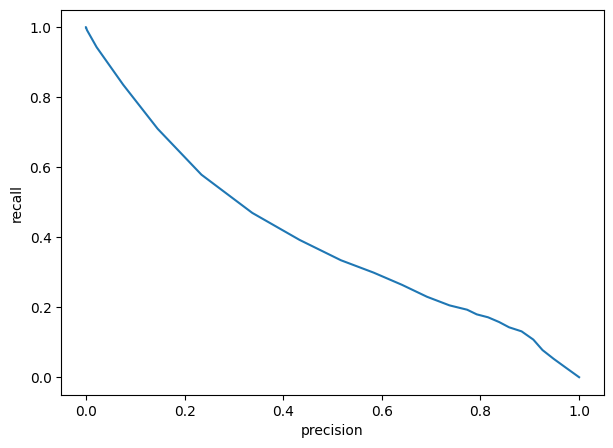

In [191]:
normed_precisions = (precisions - np.min(precisions)) / (np.max(precisions) - np.min(precisions))
normed_recalls = (recalls - np.min(recalls)) / (np.max(recalls) - np.min(recalls))
f, ax = plt.subplots(1, 1, figsize=(7, 5))
plt.plot(normed_precisions, normed_recalls)
ax.set_xlabel('precision')
ax.set_ylabel('recall')
print('AUC-PR: %.5f' % auc(normed_recalls, normed_precisions))

__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ хлопья с молоком